# Multi-Class Classification with Neural Networks

In this notebook, we will look at the multi-class classification problem using a simple feedforward neural network. We will use the MNIST dataset consisting of handwritten digit images, and leverage PyTorch and Skorch for defining and training our classification model. We will save the weights of the trained model in a json file which will be used in our zk program. We will also save some samples and their corresponding label predictions from our trained model in order to verify the correctness of our zk program.

## 1. Importing Necessary Libraries

Here, we import the libraries and packages necessary for data generation, manipulation, visualization, neural network modeling and training, and saving the model weights and test samples.

In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier

import json

## 2. Setting Random Seeds

To ensure reproducibility and get consistent results, we set random seeds for all potential sources of randomness.

In [2]:
np.random.seed(42)

torch.manual_seed(0)
torch.cuda.manual_seed(0)

## 3. Data Downloading and Preparation

For our classification task, we will download the MNIST dataset (https://en.wikipedia.org/wiki/MNIST_database). The dataset has 10 classes, corresponding to the digits 0-9. We prepare the data for our training pipeline.

In [28]:
model_name = "mnist_fc"

# Download the dataset
mnist = fetch_openml('mnist_784', as_frame=False, cache=False, parser='auto')

# Prepare the data
X, y = mnist.data.astype(np.float32), mnist.target.astype(np.int64)
X /= 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 4. Data Visualization

We visualize a few samples from the dataset.

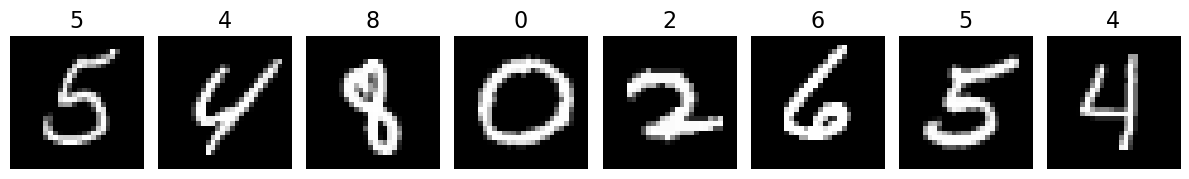

In [39]:
# Visualize the dataset
def plot_example(X, y, n_samples):
    n_cols = 8
    n_rows = math.ceil(n_samples / n_cols)
    plt.figure(figsize=(1.5*n_cols, 2*n_rows))

    for i, (img, y) in enumerate(zip(X[:n_samples].reshape(n_samples, 28, 28), y[:n_samples])):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(y, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{model_name}_visualization.png", format='png', dpi=300, bbox_inches='tight')
    plt.show()
        
plot_example(X_train, y_train, n_samples=8)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        hid = self.hidden_layer(X)
        hid_relu = self.nonlin(hid)
        hid_relu_drop = self.dropout(hid_relu)
        out = self.output_layer(hid_relu_drop)
        probs = F.softmax(out, dim=-1)
        return probs, out, hid_relu, hid

In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
class ClassifierNet(NeuralNetClassifier):
    def get_loss(self, y_pred, y_true, *args, **kwargs):
        probs, output, hid_relu, hid = y_pred
        return super().get_loss(probs, y_true, *args, **kwargs)

In [ ]:
net = ClassifierNet(
    ClassifierModule,
    max_epochs=50,
    lr=0.1)

In [ ]:
net.fit(X_train, y_train)

In [ ]:
# Making prediction for first 5 data points of X
y_pred = net.predict(X_test[:5])
y_pred

In [ ]:
y_out = net.forward(X_test[:5])
y_pred = y_out[1].numpy().argmax(1)
y_pred

In [ ]:
# Checking probarbility of each class for first 5 data points of X
y_proba = net.predict_proba(X[:5])
y_proba

In [ ]:
y_pred = net.predict(X_test)
sum(y_test == y_pred)/len(y_test)

In [ ]:
dict(net.get_all_learnable_params())['hidden_layer.weight'].detach().numpy()

In [ ]:
model_data = {}

for param in net.get_all_learnable_params():
    model_data[param[0]] = param[1].detach().numpy().flatten()
    
model_data

In [ ]:
idx = 5

In [ ]:
(X_test[idx]*(10**6)).round().astype(int)

In [ ]:
y = net.forward(X_test[idx])
y

In [ ]:
x = X_test[:5]
y = net.forward(x)
y

In [ ]:
net.forward(x)

In [ ]:
in_json = {
    "input": (x[0]*(10**6)).round().astype(int).tolist(),
    "hid_weights": (model_data['hidden_layer.weight']*(10**6)).round().astype(int).tolist(),
    "hid_bias": (model_data['hidden_layer.bias']*(10**12)).round().astype(int).tolist(),
    "out_weights":(model_data['output_layer.weight']*(10**6)).round().astype(int).tolist(),
    "out_bias": (model_data['output_layer.bias']*(10**18)).round().astype(int).tolist() # can also change to zero because we are doing argmax instead of softmax
}

In [ ]:
in_json

In [ ]:
model_json = {
    "l1_weights": (model_data['hidden_layer.weight']*(10**6)).round().astype(int).tolist(),
    "l1_biases": (model_data['hidden_layer.bias']*(10**12)).round().astype(int).tolist(),
    "lo_weights":(model_data['output_layer.weight']*(10**6)).round().astype(int).tolist(),
    "lo_biases": (model_data['output_layer.bias']*(10**18)).round().astype(int).tolist() # can also change to zero because we are doing argmax instead of softmax
}

In [ ]:
import json
with open("mnist_fc.json", "w") as f:
    json.dump(model_json, f)

In [ ]:
(y[1][0].numpy()*(10**18))

In [ ]:
out_json = {
    "scale": 10**-18,
    "out": (y[1][0].detach().numpy()*(10**18)).round().astype(int).tolist(),
    "label": int(y[1].argmax())
}
out_json

In [ ]:
import json
with open("mnist_fc_input.json", "w") as f:
    json.dump(in_json, f)
with open("mnist_fc_output.json", "w") as f:
    json.dump(out_json, f)

In [ ]:
with open('mnist_fc_test.txt', 'w') as f:
    for key in in_json:
        f.write(key + " = [")
        for idx, value in enumerate(in_json[key]):
            if(idx!=0):
                f.write(', ')
            f.write('"' + str(value) + '"')
        f.write(']\n')


In [ ]:
(y[2].numpy()*10**12).round().astype(int).tolist()

In [ ]:
(X_test*(10**6)).round().astype(int)

In [ ]:
predictions = net.predict(X_test)

In [ ]:
n_samples = 100
model_name = 'mnist_fc'

with open(f"tests_{model_name}.txt", 'w') as f:
    for i in range(len(X_test[:n_samples])):
        f.write('#[test]\n')
        f.write(f"fn test_{model_name}_{i+1:03d}" + "() {\n")
        f.write("  let sample = [")
        for idx, value in enumerate(X_test[i]):
            if(idx!=0):
                f.write(', ')
            f.write(str((value*(10**6)).round().astype(int)))
        f.write('];\n')
        f.write(f"  assert({model_name}(sample) == " + str(predictions[i]) + ");\n")
        f.write('}\n\n')

In [ ]:
n_samples = 1
model_name = 'mnist_fc'

file_name = f"run_{model_name}.sh"

file_header = """#!/bin/bash
# First check that Leo is installed.
if ! command -v leo &> /dev/null
then
    echo "leo is not installed."
    exit
fi\n"""


with open(file_name, 'w') as f:
    f.write(file_header)
    sample_dim = len(X_test[0])
    for i, sample in enumerate(X_test[:n_samples]):
        input_string = ', '.join([f'in{j+1}: {(sample[j]*(10**6)).round().astype(int)}i128' for j in range(sample_dim)])
        
        expected_value = f"{predictions[i]}u8"

        command = f'''
leo run -q compute "{{ {input_string} }}" | awk -F"• " '/u8/ {{print "Actual: "$2}}'
echo "Expected: {expected_value}"
        '''

        f.write(command)

    
# After writing, if you want to make the script executable, you can do it with os module.
import os
os.chmod(file_name, 0o755)  # Makes the script executable